# Load Dataset

In [1]:
%pip install pyspark
%pip install seaborn
%pip install seaborn matplotlib pandas numpy


Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
# imports
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql.functions import split, col, count, when, sum, expr, udf
from pyspark.sql.types import FloatType, DoubleType
from pyspark.sql.window import Window
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml import Pipeline

import math
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# from google.colab import files

In [3]:
import os
os.environ["JAVA_HOME"] = "C:\\Program Files\\Eclipse Adoptium\\jdk-8.0.442.6-hotspot"

In [4]:
from pyspark.sql import SparkSession

# Check if a Spark session already exists
spark = SparkSession.getActiveSession()
if spark is None:
    spark = SparkSession.builder.appName("NetTraffic").getOrCreate()
    print("✅ Spark session created.")
else:
    print("🔄 Using existing Spark session.")

✅ Spark session created.


In [5]:
# Path to the file (same folder as notebook)
file_path = "dataset_malware.csv" # change name if needed

# Load the CSV into a Spark DataFrame
df = spark.read.csv(file_path, header=True, inferSchema=True, sep="|")

# Light Data Exploration

## Display first 5 rows in dataset

In [33]:
# print(df_split.head())
# Show first 5 rows
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id.orig_h|id.orig_p|     id.resp_h|id.resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|      -|3.097754|         0|         0|        S0|      

## Show schema to identify column types

In [34]:
df.printSchema()

root
 |-- ts: double (nullable = true)
 |-- uid: string (nullable = true)
 |-- id.orig_h: string (nullable = true)
 |-- id.orig_p: double (nullable = true)
 |-- id.resp_h: string (nullable = true)
 |-- id.resp_p: double (nullable = true)
 |-- proto: string (nullable = true)
 |-- service: string (nullable = true)
 |-- duration: string (nullable = true)
 |-- orig_bytes: string (nullable = true)
 |-- resp_bytes: string (nullable = true)
 |-- conn_state: string (nullable = true)
 |-- local_orig: string (nullable = true)
 |-- local_resp: string (nullable = true)
 |-- missed_bytes: double (nullable = true)
 |-- history: string (nullable = true)
 |-- orig_pkts: double (nullable = true)
 |-- orig_ip_bytes: double (nullable = true)
 |-- resp_pkts: double (nullable = true)
 |-- resp_ip_bytes: double (nullable = true)
 |-- tunnel_parents: string (nullable = true)
 |-- label: string (nullable = true)
 |-- detailed-label: string (nullable = true)



## Check number of rows and columns

In [35]:
num_rows = df.count()
print(f"Number of rows: {num_rows}")
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 10447787
Number of columns: 23


# Data Cleaning

## Cast '-' to NaN change column names so that Spark will not misinterpret them

In [6]:
from pyspark.sql.functions import col, when

for column in df.columns:
    df = df.withColumn(column, when(col(f"`{column}`") == "-", None).otherwise(col(f"`{column}`")))

# Rename columns to replace dots with underscores
new_column_names = [c.replace(".", "_") for c in df.columns]
df = df.toDF(*new_column_names)

# Check
df.show(5)

+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|                 ts|               uid|    id_orig_h|id_orig_p|     id_resp_h|id_resp_p|proto|service|duration|orig_bytes|resp_bytes|conn_state|local_orig|local_resp|missed_bytes|history|orig_pkts|orig_ip_bytes|resp_pkts|resp_ip_bytes|tunnel_parents|          label|detailed-label|
+-------------------+------------------+-------------+---------+--------------+---------+-----+-------+--------+----------+----------+----------+----------+----------+------------+-------+---------+-------------+---------+-------------+--------------+---------------+--------------+
|1.545402842863612E9|CdNmOg26ZIaBRzPvWj|192.168.1.196|  59932.0|104.248.160.24|     80.0|  tcp|   NULL|3.097754|         0|         0|        S0|      

## Dealing with missing values

In [7]:
from pyspark.sql.functions import col, sum as spark_sum

null_values = (
    df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ])
    .toPandas()
    .T.rename(columns={0: "Count"})
)

display(null_values)

,Count
ts,0
uid,0
id_orig_h,0
id_orig_p,0
id_resp_h,0
id_resp_p,0
proto,0
service,10446261
duration,4432615
orig_bytes,4432615


Since duration, orig_bytes, resp_bytes all have same number of null values (4432615), very likely they are from the same few rows. All three columns are critical for modelling so it is best to drop the rows containing null values in those fields.

Others like service, local_orig, local_resp, tunnel_parents amd detailed_label all have more than 10446261 out of 10447787 null values. These will not help our model and will just bloat memory, so we can drop these columns.

22 nulls in history can be dropped too.

In [8]:
from pyspark.sql.functions import when, col

# Columns to clean:
columns_to_clean = ['duration', 'orig_bytes', 'resp_bytes', 'history']

# Replace "NULL" or "null" strings with actual nulls (None)
for c in columns_to_clean:
    df = df.withColumn(c, when((col(c) == "NULL") | (col(c) == "null"), None).otherwise(col(c)))

# Drop rows where any of these are null
df = df.dropna(subset=columns_to_clean)

from pyspark.sql.functions import col, sum as spark_sum

# Drop columns with largely null values
columns_to_drop = ["service", "local_orig", "local_resp", "tunnel_parents", "detailed-label"]
df = df.drop(*columns_to_drop)


null_values = (
    df.select([
        spark_sum(col(c).isNull().cast("int")).alias(c)
        for c in df.columns
    ])
    .toPandas()
    .T.rename(columns={0: "Count"})
)

display(null_values)

,Count
ts,0
uid,0
id_orig_h,0
id_orig_p,0
id_resp_h,0
id_resp_p,0
proto,0
duration,0
orig_bytes,0
resp_bytes,0


They are indeed from the same few rows. now there are 0 NULL count for duration, orig_bytes and resp_bytes.

# Deeper Data Exploration

## Checking for Distribution of Target Variable


In [9]:
# Register DataFrame as a SQL table
df.createOrReplaceTempView("malware_data")

# Define SQL Query to count the number of rows with 0 and 1 in the target variable
query = """
SELECT
    label,
    COUNT(*) AS count
FROM
    malware_data
GROUP BY
    label
"""

# Run the SQL query
result = spark.sql(query)
result.show()

+------------------+-------+
|             label|  count|
+------------------+-------+
|            Benign|4108318|
|   Malicious   C&C|     33|
|Malicious   Attack|      3|
|  Malicious   DDoS|1906796|
+------------------+-------+



Malicious C&C and Mallitics Attack have significantly lower count than the other classes, causing severe imbalance. We decided to drop them.

In [10]:
from pyspark.sql.functions import col

# Filter the DataFrame to keep only 'Benign' and 'Malicious   DDoS' labels
df = df.filter(
    (col("label") == "Benign") | 
    (col("label") == "Malicious   DDoS")
)

In [11]:
num_rows = df.count()
print(f"Number of rows: {num_rows}")
num_columns = len(df.columns)
print(f"Number of columns: {num_columns}")

Number of rows: 6015114
Number of columns: 18


In [12]:
# Register DataFrame as a SQL table
df.createOrReplaceTempView("malware_data")

# Define SQL Query to count the number of rows with 0 and 1 in the target variable
query = """
SELECT
    label,
    COUNT(*) AS count
FROM
    malware_data
GROUP BY
    label
"""

# Run the SQL query
result = spark.sql(query)
result.show()

+----------------+-------+
|           label|  count|
+----------------+-------+
|          Benign|4108318|
|Malicious   DDoS|1906796|
+----------------+-------+



Roughly 2:1 ratio, mildly imbalanced.

## Summary statistics for numeric columns

In [ ]:
# convert numerical columns
cols_to_convert = [
    "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# Convert to FloatType
for column in cols_to_convert:
    df = df.withColumn(column, col(column).cast(FloatType()))

# Descriptive stats with Pandas for nicer formatting
desc_stats = df.describe(cols_to_convert)
desc_stats_pd = desc_stats.toPandas().set_index('summary').T
display(desc_stats_pd)

summary,count,mean,stddev,min,max
duration,6015136,4.223807251961909,9.869124951743423,2.0E-6,582.169
orig_bytes,6015136,3.560142356189428E8,3.46770275955462E9,0.0,6.6205577E10
resp_bytes,6015136,5591.376293902582,1.2956937373334212E7,0.0,3.17205115E10
missed_bytes,6015136,317.3408574635719,778291.2134145867,0.0,1.90881946E9
orig_pkts,6015136,6.343712261867396,3000.962278839396,0.0,4027345.0
orig_ip_bytes,6015136,271.38145455065353,84027.25369643705,0.0,1.12765664E8
resp_pkts,6015136,0.001142285062216382,0.3421853741378431,0.0,279.0
resp_ip_bytes,6015136,0.6466432346666808,494.1573836462667,0.0,413488.0


## Boxplots for numerical variables

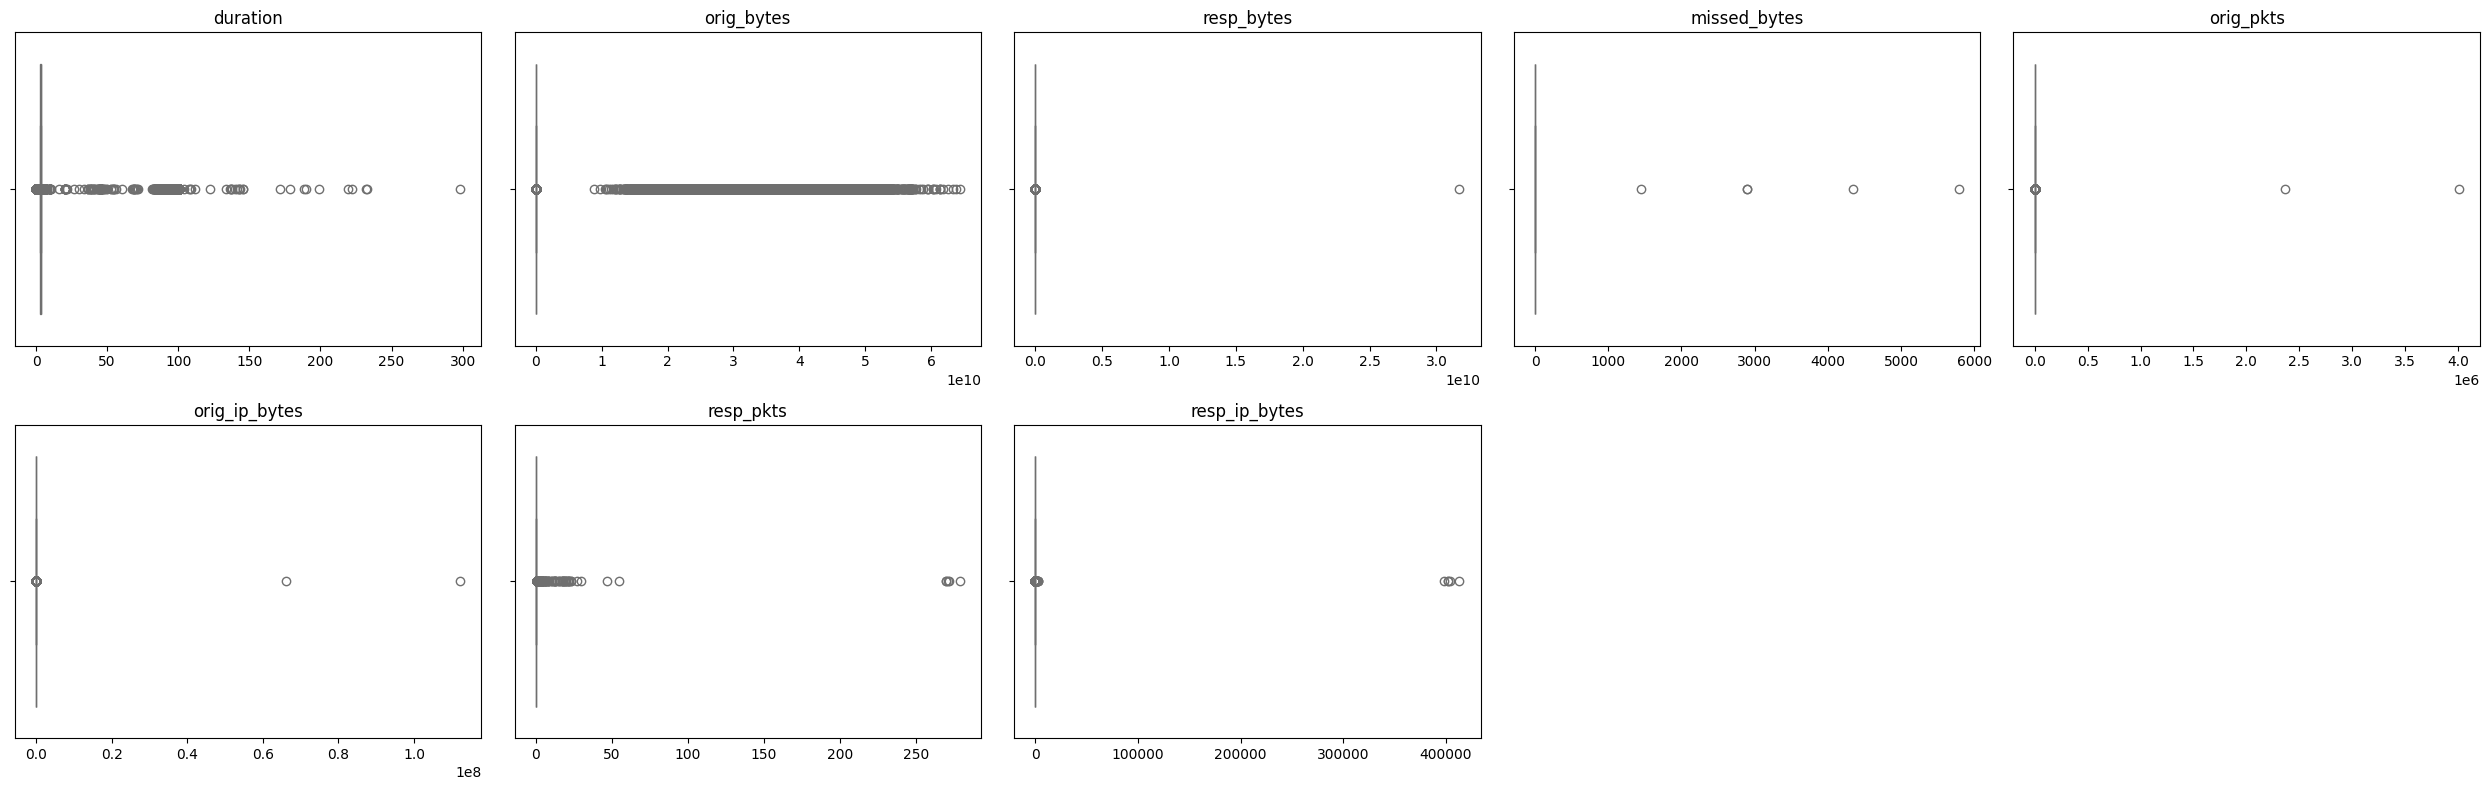

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Use your actual numeric variables (but check for existence)
all_numeric_cols = [
    "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# Filter only columns that exist in df
numeric_cols = [col_name for col_name in all_numeric_cols if col_name in df.columns]

# Optional: handle nulls before collecting (replace with 0 or drop rows)
from pyspark.sql.functions import when, isnan

for col_name in numeric_cols:
    df = df.withColumn(col_name, when(
        (col(col_name).isNull()) | (isnan(col(col_name))), 0
    ).otherwise(col(col_name)))

# Sample to avoid memory issues (optional)
df_sample = df.select(numeric_cols).sample(False, 0.5, seed=42)

# Convert to pandas for plotting
df_pandas = df_sample.toPandas()

# Plot boxplots
num_cols = 5
num_vars = len(numeric_cols)
num_rows = (num_vars + num_cols - 1) // num_cols

fig, axes = plt.subplots(num_rows, num_cols, figsize=(5 * num_cols, 4 * num_rows))
axes = axes.flatten()

for i, col_name in enumerate(numeric_cols):
    sns.boxplot(x=df_pandas[col_name], ax=axes[i], color='skyblue')
    axes[i].set_title(col_name)
    axes[i].set_xlabel("")  # cleaner look

# Remove empty plots
for i in range(num_vars, len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Categorical Value Distibution

In [21]:
categorical_cols = ["proto", "conn_state", "history"]

for col in categorical_cols:
    count_df = df.groupBy(col).count().orderBy("count", ascending=False).toPandas()
    print(f"=== {col} Value Counts ===")
    display(count_df)


ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

In [ ]:
from pyspark.sql.functions import countDistinct

# Count distinct values for each column
cardinality = df.select(
    countDistinct("id_orig_h").alias("id_orig_h_cardinality"),
    countDistinct("id_orig_p").alias("id_orig_p_cardinality"),
    countDistinct("id_resp_h").alias("id_resp_h_cardinality"),
    countDistinct("id_resp_p").alias("id_resp_p_cardinality")
).collect()[0]

# Print the cardinality of each column
print(f"Cardinality of id_orig_h: {cardinality['id_orig_h_cardinality']}")
print(f"Cardinality of id_orig_p: {cardinality['id_orig_p_cardinality']}")
print(f"Cardinality of id_resp_h: {cardinality['id_resp_h_cardinality']}")
print(f"Cardinality of id_resp_p: {cardinality['id_resp_p_cardinality']}")

Cardinality of id_orig_h: 28
Cardinality of id_orig_p: 65536
Cardinality of id_resp_h: 4098966
Cardinality of id_resp_p: 16


id_orig_h has low cardinality -> 28, so likely represent small number of internal source IPs (devices on your network)

id_resp_p has low cardinality -> 16 destination ports, likely standard ones like 80, 443, 22. tells you what kind of service was accessed. 

## Correlation matrix for numeric columns

In [22]:
from pyspark.sql.types import FloatType, DoubleType

# Define numeric features to keep (excluding ID-like columns)
numeric_cols = [
    "duration", "orig_bytes", "resp_bytes",
    "missed_bytes", "orig_pkts", "orig_ip_bytes", "resp_pkts", "resp_ip_bytes"
]

# Convert PySpark DataFrame to pandas DataFrame for correlation calculation
pandas_df = df.select(numeric_cols).toPandas()

# Plot correlation heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pandas_df.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Between Numeric Features")
plt.show()

ConnectionRefusedError: [WinError 10061] No connection could be made because the target machine actively refused it

(need to rewrite as we using different dataset)
From the correlation matrix, it can be seen that:
1. Strong Positive Correlation (Close to 1.0)
  - `orig_pkts` and `orig_ip_bytes` are perfectly correlated (1.00), suggesting that packet count and total IP bytes from the origin are directly proportional. One of the variables could be dropped to reduce redundancy.
  - `resp_bytes` and `resp_ip_bytes` are similarly strongly correlated (0.98). This could also mean one of the columns might be redundant.
  - `duration` and `resp_pkts` are also strongly correlated (0.95). This makes sense as longer durations correlate with more response packets, indicating sustained communication during the duration.
2. Weak/Negligible Correlations (Close to 0):
  - Port numbers (`id.orig_p`, `id.resp_p`) have near-zero correlations with other features suggesting that ports do not directly influence traffic metrics (e.g. duration, bytes). This is expected as ports are identifiers, not quantitative measures.
  - Except for its strong positive correlation to `resp_ip_bytes`, `resp_bytes` and most other features have weak/negligible correlations (0.00-0.21) possibly indicating isolated response behaviors.

## Mutual Information Scoring

In [ ]:
# Discretise numerical features
numeric_cols = [col_name for col_name, dtype in df.dtypes if dtype in ['int', 'double', 'float']]

# compute mutual info
def compute_mutual_info(df, feature_col, target_col="label", n_bins=5):
    # 5 quantile based bins per numerical col
    if feature_col in numeric_cols:
        df = df.withColumn(
            f"{feature_col}_bin",
            F.ntile(n_bins).over(Window.orderBy(feature_col)))
        feature_col = f"{feature_col}_bin"

    # Compute joint probability P(X,Y)
    joint_prob = (
        df.groupBy(feature_col, target_col)
        .agg(F.count("*").alias("count"))
        .withColumn("p_xy", F.col("count") / df.count())
    )

    # Compute marginal probabilities P(X) and P(Y)
    p_x = joint_prob.groupBy(feature_col).agg(F.sum("p_xy").alias("p_x"))
    p_y = joint_prob.groupBy(target_col).agg(F.sum("p_xy").alias("p_y"))

    # Calculate MI terms: p_xy * log2(p_xy / (p_x * p_y))
    mi_terms = (
        joint_prob.join(p_x, feature_col)
        .join(p_y, target_col)
        .withColumn(
            "mi_term",
            F.col("p_xy") * F.log2(F.col("p_xy") / (F.col("p_x") * F.col("p_y")))
        )
    )

    # Sum MI terms to get final score
    mi = mi_terms.agg(F.sum("mi_term").alias("mi")).collect()[0]["mi"]
    return float(mi) if mi else 0.0

# Compute MI for all features
df_mis = df.select("*")
mi_results = {}

for feature in df_mis.columns:  # Combine all features
    if feature == "label":
        continue
    mi_score = compute_mutual_info(df_mis, feature)
    mi_results[feature] = mi_score
    print(f"MI for {feature}: {mi_score:.4f}")

# Sort the MI and display results
sorted_mi_results = sorted(mi_results.items(), key=lambda x: x[1], reverse=True)
print("\n=== Features sorted by Mutual Information ===")
for feature, mi_score in sorted_mi_results:
    print(f"{feature}: {mi_score:.4f}")

MI for ts: 0.0007
MI for uid: 0.0282
MI for id_orig_h: 0.0072
MI for id_orig_p: 0.0025
MI for id_resp_h: 0.0278
MI for id_resp_p: 0.0016
MI for proto: 0.0116
MI for duration: 0.0039
MI for orig_bytes: 0.0024
MI for resp_bytes: 0.0004
MI for conn_state: 0.0230
MI for history: 0.0176
MI for orig_pkts: 0.0010
MI for orig_ip_bytes: 0.0017
MI for resp_pkts: 0.0023
MI for resp_ip_bytes: 0.0023
MI for detailed-label: 0.0056

=== Features sorted by Mutual Information ===
uid: 0.0282
id_resp_h: 0.0278
conn_state: 0.0230
history: 0.0176
proto: 0.0116
id_orig_h: 0.0072
detailed-label: 0.0056
duration: 0.0039
id_orig_p: 0.0025
orig_bytes: 0.0024
resp_pkts: 0.0023
resp_ip_bytes: 0.0023
orig_ip_bytes: 0.0017
id_resp_p: 0.0016
orig_pkts: 0.0010
ts: 0.0007
resp_bytes: 0.0004


(need to rewrite as we using different dataset now)
**Interpretation of Mutual Information (MI) Scoring:**

MI scoring is a measure of how much information one variable (feature) provides about another (target variable, in this case, `label`). It helps identify which features are most relevant for predicting the target, where a higher MI score means the feature is more informative for the prediction and should be prioritised for model training.

From the results:
The top 5 informative features are
1. `uid` (0.0282)
2. `id_resp_h` (0.0278)
3. `conn_state` (0.0230)
4. `history` (0.0176)
5. `proto` (0.0116)

On the other hand, the features with low/zero MI score are `resp_bytes` (0.0004) and `ts` (0.0007) which have very low MI and may have a negligible effect on prediction.

**Data Leakage Issue**

While `uid` has a high MI score, it could suggest that the `uid` is leaking information about the `label` as `uid` is supposed to be a unique identifier for the connection. Since it is unique per row, it has zero predictive power on new data and cannot be generalised onto new samples. This could cause the model to perform extremely well on training data but fail on unseen data.

# Feature Engineering

## Engineering new Meaningful Features

In [14]:
from pyspark.sql.functions import col, when, lit, log1p

# Total Bytes
# Byte Ratio (orig_bytes / (resp_bytes + 1))
# Packet Ratio (orig_pkts / (resp_pkts + 1))
# Total Packet Count
# Throughput = total_bytes / (duration + 1e-6)
# Data-to-packet efficiency

df = df \
    .withColumn("total_bytes", col("orig_bytes") + col("resp_bytes")) \
    .withColumn("byte_ratio", col("orig_bytes") / (col("resp_bytes") + lit(1))) \
    .withColumn("pkt_ratio", col("orig_pkts") / (col("resp_pkts") + lit(1))) \
    .withColumn("total_pkts", col("orig_pkts") + col("resp_pkts")) \
    .withColumn("throughput", col("total_bytes") / (col("duration") + lit(1e-6))) \
    .withColumn("efficiency", col("total_bytes") / (col("total_pkts") + lit(1)))



## Train-Test Split and label indexing

In [15]:
from pyspark.ml.feature import StringIndexer

# Create a label indexer for string labels.
label_indexer = StringIndexer(inputCol="label", outputCol="label_index", handleInvalid="keep")

df = label_indexer.fit(df).transform(df)

# Show results to verify
df.select("label", "label_index").show(10)


+------+-----------+
| label|label_index|
+------+-----------+
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
|Benign|        0.0|
+------+-----------+
only showing top 10 rows



In [16]:
train_df, test_df = df.randomSplit([0.8, 0.2], seed=42)

## Encoding of Categorical Variables:

Categorical varaiables included are History, proto, conn_state, and id_resp_p. From data exploration, cardinality of each of them are 61, 3, 11, 16 respectively.

History has high cardinality so need to do frequency encoding.
Others have relative low cardinality so one-hot encoding is feasible.

In [17]:
from pyspark.sql.functions import count

# for high cardinality categorical features, use frequency encoding

history_freq_train = train_df.groupBy("history").count().withColumnRenamed("count", "history_freq")

# Join the frequency mapping to the training data.
train_df = train_df.alias("left") \
    .join(history_freq_train.alias("right"), col("left.history") == col("right.history"), "left") \
    .select("left.*", col("right.history_freq"))

# Join the same mapping to the test data.
test_df = test_df.join(history_freq_train, on="history", how="left")
# Fill null values in test set for unseen "history" categories (if any) with 0.
test_df = test_df.fillna({"history_freq": 0.0})


In [18]:
from pyspark.ml.feature import StringIndexer, OneHotEncoder

# Low-cardinality categorical features to one-hot encode:
low_card_cat = ["proto", "conn_state", "id_resp_p"]

# Create StringIndexers for low-cardinality features.
indexers = [StringIndexer(inputCol=cat, outputCol=cat + "_index", handleInvalid="keep")
            for cat in low_card_cat]

# Create OneHotEncoders for the indexed features.
encoders = [OneHotEncoder(inputCol=cat + "_index", outputCol=cat + "_vec")
            for cat in low_card_cat]

In [19]:
print(train_df.columns)


['ts', 'uid', 'id_orig_h', 'id_orig_p', 'id_resp_h', 'id_resp_p', 'proto', 'duration', 'orig_bytes', 'resp_bytes', 'conn_state', 'missed_bytes', 'history', 'orig_pkts', 'orig_ip_bytes', 'resp_pkts', 'resp_ip_bytes', 'label', 'total_bytes', 'byte_ratio', 'pkt_ratio', 'total_pkts', 'throughput', 'efficiency', 'label_index', 'history_freq']


## Scaling of Numerical Features

In [20]:
from pyspark.ml.feature import VectorAssembler, StandardScaler

# List of numerical features to scale.
numeric_features = ["duration", "byte_ratio", "pkt_ratio",
                    "total_bytes", "total_pkts", "efficiency", "throughput", "history_freq"]

# Ensure numeric feature columns are of type double.
for feature in numeric_features:
    train_df = train_df.withColumn(feature, col(feature).cast("double"))
    test_df = test_df.withColumn(feature, col(feature).cast("double"))

# Assemble numeric features into a vector.
assembler_num = VectorAssembler(inputCols=numeric_features, outputCol="num_features")

# Scale numerical features using StandardScaler.
scaler = StandardScaler(inputCol="num_features", outputCol="features_scaled")

## Assemble Features

In [22]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.classification import LogisticRegression

final_assembler = VectorAssembler(
    inputCols=["features_scaled"] + [cat + "_vec" for cat in low_card_cat] + ["history_freq"],
    outputCol="features"
)


# Model Training and Evaluation

## Logistic Regression

In [23]:
lr = LogisticRegression(featuresCol="features", labelCol="label_index", maxIter=20, regParam=0.1)

pipeline = Pipeline(stages=indexers + encoders + [assembler_num, scaler, final_assembler, 
    lr])


## Hyperparameter Tunning and k-fold validation

In [25]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator

# Setup parameter grid for Logistic Regression.
paramGrid = ParamGridBuilder() \
    .addGrid(lr.regParam, [0.01, 0.1]) \
    .addGrid(lr.elasticNetParam, [0.0]) \
    .build()

# Define evaluator using area under ROC.
evaluator = MulticlassClassificationEvaluator(labelCol="label_index", metricName="accuracy")

# Setup 3-fold cross-validation.
cv = CrossValidator(
    estimator=pipeline,
    estimatorParamMaps=paramGrid,
    evaluator=evaluator,
    numFolds=3
)

# Train the model using cross-validation on the training set.
cvModel = cv.fit(train_df)



In [26]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator# Make predictions on the test set.
predictions = cvModel.transform(test_df)

# Evaluate using AUC.
auc = evaluator.evaluate(predictions)
print(f"Test AUC: {auc:.4f}")

# Evaluate using Accuracy.
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(predictions)
print(f"Test Accuracy: {accuracy:.4f}")

# Evaluate using F1 Score.
f1_evaluator = MulticlassClassificationEvaluator(labelCol="label_index", predictionCol="prediction", metricName="f1")
f1 = f1_evaluator.evaluate(predictions)
print(f"Test F1 Score: {f1:.4f}")

# Show sample predictions.
predictions.select("label_index", "prediction", "probability").show(10, truncate=False)

Test AUC: 1.0000
Test Accuracy: 1.0000
Test F1 Score: 1.0000
+-----------+----------+--------------------------------------------------------------+
|label_index|prediction|probability                                                   |
+-----------+----------+--------------------------------------------------------------+
|0.0        |0.0       |[0.9907149802354839,0.009227392680974205,5.762708354181235E-5]|
|0.0        |0.0       |[0.9907151801974939,0.009227193398812365,5.76264036937016E-5] |
|0.0        |0.0       |[0.9907149805561322,0.009227392361416318,5.762708245165082E-5]|
|0.0        |0.0       |[0.9907149801954028,0.00922739272091894,5.762708367808263E-5] |
|0.0        |0.0       |[0.9907149804358891,0.009227392481250516,5.762708286046142E-5]|
|0.0        |0.0       |[0.9907150603570749,0.009227312831786835,5.762681113831902E-5]|
|0.0        |0.0       |[0.9907149706160373,0.009227402267716062,5.76271162466679E-5] |
|0.0        |0.0       |[0.9907149904962165,0.0092273824551

## Random Forest

In [ ]:
# to be filled

## Gradient Boosted Trees

In [26]:
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml import Pipeline

# gbt regressor
gbt = GBTClassifier(featuresCol="features",
                    labelCol="label_index", 
                    maxIter=50, 
                    maxDepth=5)
# gbt pipeline
gbt_pipeline = Pipeline(stages=[
    label_indexer,
    encoder, # insert encoders !!
    assembler,
    gbt
])
# train the model
gbt_model = gbt_pipeline.fit(train)

# Make predictions with Gradient Boosted Tree
gbt_predictions = gbt_model.transform(test)

# evaluate AUC using BinaryClassificationEvaluator
evaluator_auc = BinaryClassificationEvaluator(
    labelCol="label_index",
    rawPredictionCol="rawPrediction",  # GBT outputs rawPrediction
    metricName="areaUnderROC"
)

gbt_auc = evaluator_auc.evaluate(gbt_predictions)
print(f"GBT AUC: {gbt_auc:.4f}")

evaluator_acc = MulticlassClassificationEvaluator(
    labelCol="label_index", 
    predictionCol="prediction", 
    metricName="accuracy"
)

gbt_accuracy = evaluator_acc.evaluate(gbt_predictions)
print(f"Accuracy: {gbt_accuracy:.4f}")

NameError: name 'encoder' is not defined

## MLP

In [ ]:
# to be filled

# Hyperparameter Tuning & Cross-Validation

In [ ]:
# to be done

# Model Comparison

write interpretations here